# Erzincan 1008 Toplantıları [#H1]
1. jenerasyon (gen1), tamamen bağlı (fully connected) bir yapay sinir ağı (ANN) modelinin anlaşılması ve Pytorch ile gerçeklenmesini amaçlıyoruz.

!!: Bu not defterleri sürekli iyileştirilmektedir. Bu nedenle ulaştığınız içerik geçici bir süreliğine eksik/bozuk/yanlış görünebilir.

## Fonksiyonların Yakın Değerlerini Üretmek için Yapay Sinir Ağları
Function Approximator: Herhangi bir fonksiyonu hesaplamadan yakın değerler üreten bir algoritma veya model

Amacımızın iki veri kümesi arasındaki ilişkiyi modellemek olduğunu varsayalım. Bu ilişki matematiksel olarak ifade ediliyor veya edilemiyor olabilir. Bu senaryoda, birden fazla katmana sahip bir yapay sinir ağı modeli giriş ve çıkış verisi arasındaki ilişkiyi modelleyebilir.

Örneğin, $$f(t) = t^2$$ gibi bir fonksiyonda giriş verisi t ile çıkış verisi f(t) arasındaki ilişki matematiksel olarak ifade edilebilir. Herhangi bir $$t$$ değerinin karşılığı olan $$f(t)$$ değerini hesaplamak için değeri kendisi ile çarpmak yeterlidir. 

Bu basit ilişki bir sinir ağı model tarafından öğrenilebilir mi? Rastgele sayıda seçilmiş ve katmanlar halinde bağlanmış birkaç yapay sinir hücresinden oluşan bir ağ modeli bu ilişkiyi öğrenerek $$f(t)$$ fonksiyonu için yakın değerler üretebilir.


## Tamamen Bağlı Bir Ağ Modeli
Bu kısımda ANN açıklanacak.

## Veri Üretmek

güncellenecek.

In [1]:
import torch
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

df= pd.read_csv(r"data/heart_attack dataset/heart.csv")


In [2]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
# Bağımsız değişkenler (X) ve bağımlı değişkenler (y) olarak ayırma
X = df.iloc[:, :-1]  # Tüm sütunlar, son sütun hariç
y = df.iloc[:, -1]   # Sadece son sütun

# Kontrol
print(X.head())
print(y.head())


   age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  
0    0      1  
1    0      2  
2    0      2  
3    0      2  
4    0      2  
0    1
1    1
2    1
3    1
4    1
Name: output, dtype: int64


In [4]:
# Eksik değer kontrolü
print(df.isnull().sum())

# Eksik değerleri doldurma (örneğin, ortalama ile)
X.fillna(X.mean(), inplace=True)

# Veri türlerini kontrol et
print(df.dtypes)


age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64
age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object


In [5]:
# kategorik bir sütunu one-hot encoding yapma(Eğer herhangi bir sütun kategorikse (ör. object türündeyse), bunları one-hot encoding veya label encoding ile sayısal hale getirilir.)
X = pd.get_dummies(X, drop_first=True)


In [6]:


# numpy verimizi Tensörlere dönüştür
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)  # Eğer y bir sınıflandırma problemi ise `long` kullanabilirsiniz


In [7]:


class HeartDataset(Dataset):
    def __init__(self, file_path):
        # CSV dosyasını oku
        self.data = pd.read_csv(file_path)

        # Eksik değerleri doldur
        self.data.fillna(self.data.mean(), inplace=True)

        # Bağımsız ve bağımlı değişkenleri ayır
        self.X = self.data.iloc[:, :-1]
        self.y = self.data.iloc[:, -1]

        # Gerekirse kategorik verileri sayısal hale getir
        self.X = pd.get_dummies(self.X, drop_first=True)

        # Tensörlere dönüştür
        self.X = torch.tensor(self.X.values, dtype=torch.float32)
        self.y = torch.tensor(self.y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [8]:
from torch.utils.data import DataLoader

# Dataset oluştur
dataset = HeartDataset(r"data/heart_attack dataset/heart.csv")

# DataLoader ile veri yükleyici oluştur
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Veri yükleme örneği
for batch_X, batch_y in dataloader:
    print(batch_X.shape, batch_y.shape)
    break


torch.Size([32, 13]) torch.Size([32])


In [9]:

#Modelinizi oluşturmak için PyTorch'un nn.Module sınıfını kullanabilirz. Örnek bir yapay sinir ağı:

import torch.nn as nn

class HeartModel(nn.Module):
    def __init__(self, input_size):
        super(HeartModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)  # İlk katman
        self.relu = nn.ReLU()                # Aktivasyon
        self.fc2 = nn.Linear(16, 1)          # Çıkış katmanı
        self.sigmoid = nn.Sigmoid()          # Sınıflandırma için Sigmoid

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


In [10]:
# Giriş boyutunu veri setinden otomatik alabiliriz
input_size = dataset.X.shape[1]  # Bağımsız değişkenlerin boyutu
model = HeartModel(input_size)


In [11]:
import torch.optim as optim

# Kayıp fonksiyonu
criterion = nn.BCELoss()  # Binary Cross Entropy Loss

# Optimizatör
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [12]:
# Eğitim parametreleri
epochs = 20  # Eğitim döngüsü sayısı

for epoch in range(epochs):
    model.train()  # Eğitim moduna geç
    running_loss = 0.0

    for batch_X, batch_y in dataloader:
        # Çıkışın boyutunu y ile aynı hale getir
        batch_y = batch_y.unsqueeze(1)

        # Optimizatörü sıfırla
        optimizer.zero_grad()

        # İleri yayılım
        outputs = model(batch_X)

        # Kayıp hesapla
        loss = criterion(outputs, batch_y)

        # Geri yayılım
        loss.backward()

        # Optimizasyon adımı
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloader):.4f}")


Epoch 1/20, Loss: 2.9718
Epoch 2/20, Loss: 0.9507
Epoch 3/20, Loss: 0.9009
Epoch 4/20, Loss: 0.7630
Epoch 5/20, Loss: 0.7313
Epoch 6/20, Loss: 0.7302
Epoch 7/20, Loss: 0.7072
Epoch 8/20, Loss: 0.7012
Epoch 9/20, Loss: 0.6857
Epoch 10/20, Loss: 0.6735
Epoch 11/20, Loss: 0.6615
Epoch 12/20, Loss: 0.6499
Epoch 13/20, Loss: 0.6433
Epoch 14/20, Loss: 0.6452
Epoch 15/20, Loss: 0.6359
Epoch 16/20, Loss: 0.6252
Epoch 17/20, Loss: 0.6292
Epoch 18/20, Loss: 0.6017
Epoch 19/20, Loss: 0.5907
Epoch 20/20, Loss: 0.5740


In [13]:
def evaluate_model(model, dataloader):
    model.eval()  # Değerlendirme moduna geç
    correct = 0
    total = 0

    with torch.no_grad():  # Gradient hesaplamalarını kapat
        for batch_X, batch_y in dataloader:
            # Çıkışın boyutunu y ile aynı hale getir
            batch_y = batch_y.unsqueeze(1)

            # Tahmin
            outputs = model(batch_X)
            predicted = (outputs > 0.5).float()  # 0.5 eşik değeri
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")

# Modeli değerlendirme
evaluate_model(model, dataloader)


Accuracy: 70.63%


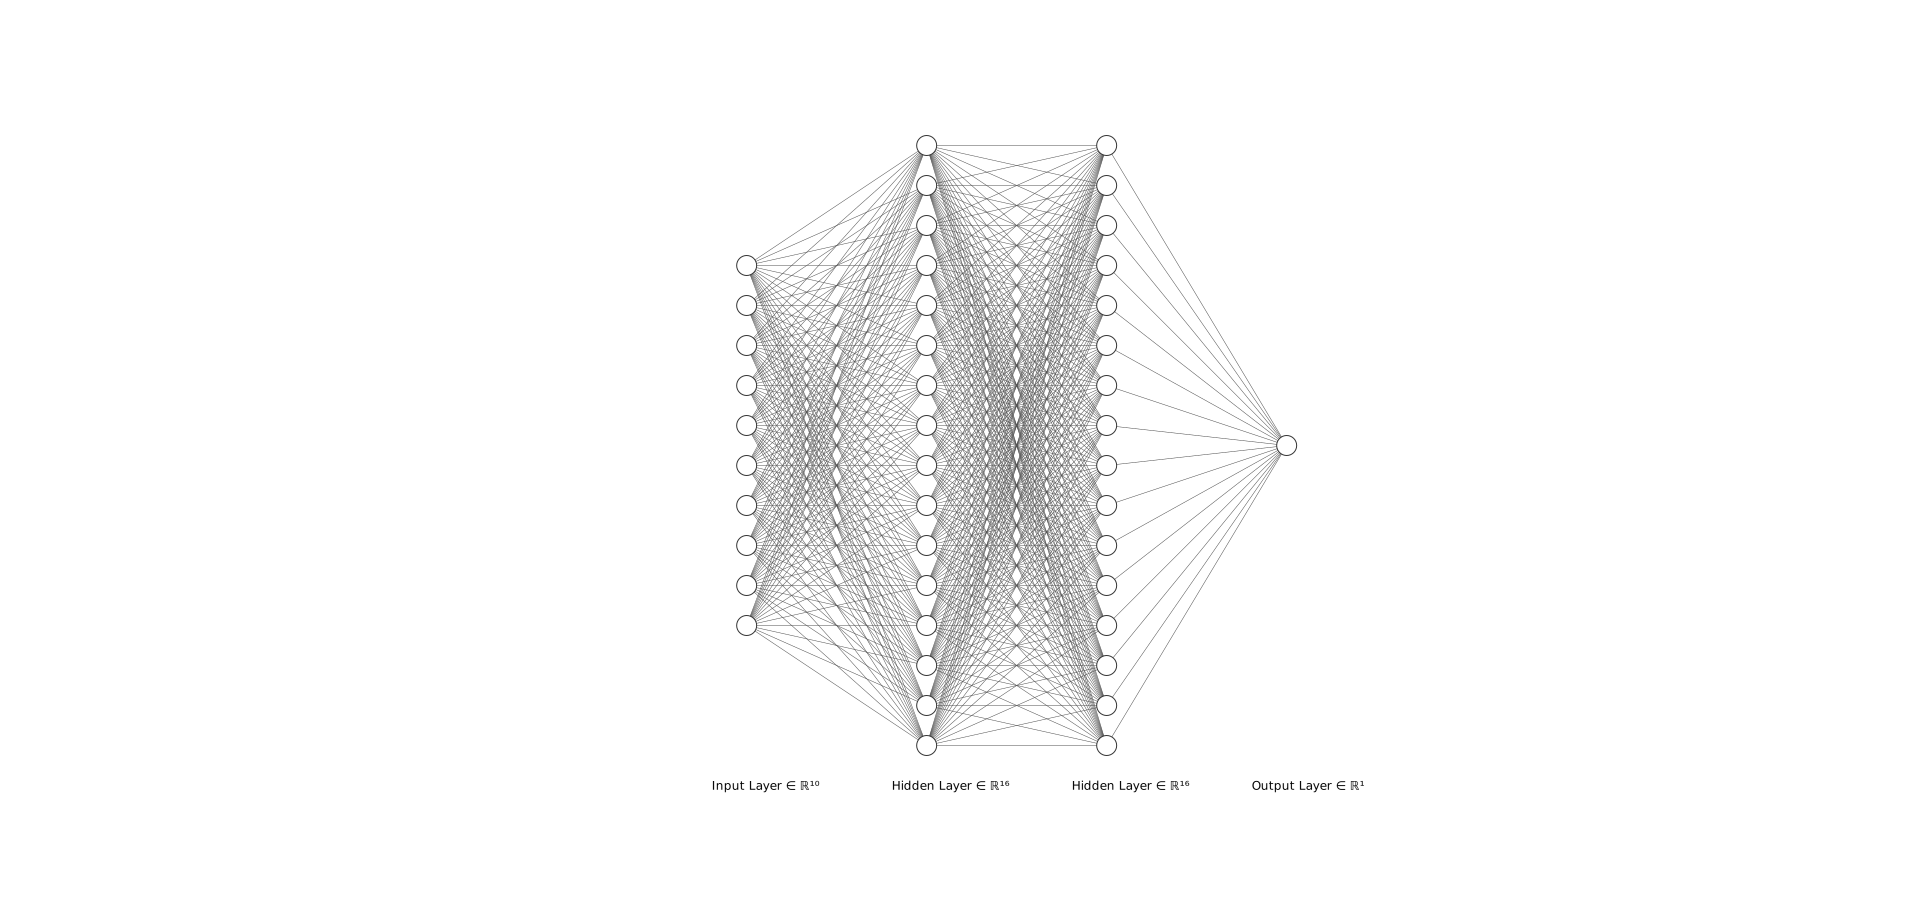

In [15]:
from IPython.display import SVG, display

# Resmi notebook içinde göstermek
file_path = "nn.svg"  # Resim dosyasının yolu
display(SVG(file_path))


## Herhangi Bir Veriden Veri Kümesi Oluşturmak
Problemi incelemek için üretilen veri veya elinizdeki herhangi bir veriyi Pytorch ile kullanmak için torch.utils.data.Dataset formatına dönüştürmeniz gerekmektedir. Verileri tutacak sınıf Dataset sınıfından türetilmelidir. Temel olarak bir dataset sınıfının __len__ ve __getitem__ fonksiyonlarını yeniden tanımlamak yeterlidir. Veri kümesinin torch ile işlenebilmesi için boyutunun __len__ fonksiyonu ile hesaplanabiliyor olması gerekir. Ayrıca veri kümesinden herhangi bir eleman __getitem__ fonksiyonu ile çekilebilir. Bu fonksiyon argüman olarak bir index alır ve veri kümesinde bu indexte bulunan veriyi döner. Aşağıdaki örnekte veri giriş ve çıkış şeklinde dönülmüştür.

In [14]:
import torch
from torch.utils.data import Dataset

class SquareDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).unsqueeze(1).float()
        self.y = torch.from_numpy(y).unsqueeze(1).float()
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

x2_dataset = SquareDataset(t, y)
train_loader = torch.utils.data.DataLoader(x2_dataset, batch_size=20, shuffle=True)
print(x2_dataset.__len__())
print(train_loader.__len__())

NameError: name 't' is not defined

## Basit bir MLP (Multi Layer Perceptron)

In [ ]:
import torch.nn as nn

class Square(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Linear(1, 64),
                                    nn.LeakyReLU())
        
        self.layer2 = nn.Sequential(nn.Linear(64, 1))
        
    def forward(self, x):
        a = self.layer1(x)
        b = self.layer2(a)
        return b

model = Square()    

## Kayıp Fonksiyonu ve Optimizer

In [ ]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=3e-4, momentum=0.9)

## Eğitim Döngüsü

In [ ]:
#%% Train
loss_hist = []
for epoch in range(50):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
            inputs, labels = data
            optimizer.zero_grad()
            
            y = model(inputs)
            
            e = loss_fn(y, labels)
            e.backward()
            
            optimizer.step()
            
            running_loss += e.item()
            
    running_loss = running_loss/10
    loss_hist.append(running_loss)


pred_y = model(torch.from_numpy(t).float().unsqueeze(1)).detach().numpy()[:,0]
plt.plot(t, pred_y, '+')

In [ ]:
plt.figure()
plt.plot(loss_hist)